In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

%matplotlib inline
from nltk import tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.models import Model

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
data=pd.read_csv('../input/mbti-type/mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer() 
cachedStopWords = stopwords.words("english")

def cleaning_data(data, remove_stop_words=True):
    list_posts = []
    i=0   
    for row in data.iterrows():
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', posts) #remove urls
        temp = re.sub("[^a-zA-Z.]", " ", temp) #remove all punctuations except fullstops.
        temp = re.sub(' +', ' ', temp).lower() 
        temp=re.sub(r'\.+', ".", temp) #remove multiple fullstops.
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
        list_posts.append(temp)

    text = np.array(list_posts)
    return text

In [5]:
clean_text = cleaning_data(data, remove_stop_words=True)
data['clean_text']=clean_text
data = data[['clean_text', 'type']]
data.head()

,clean_text,type
0,enfp intj moment sportscenter top ten play pr...,INFJ
1,finding lack post alarming. sex boring positi...,ENTP
2,good one course say know blessing curse. abso...,INTP
3,dear intp enjoyed conversation day. esoteric ...,INTJ
4,fired. another silly misconception. approachi...,ENTJ


In [6]:
types=data['type']
text=data['clean_text']
tps=data.groupby('type')
print("total types:",tps.ngroups)
print(tps.size())

total types: 16
type
ENFJ     190
ENFP     675
ENTJ     231
ENTP     685
ESFJ      42
ESFP      48
ESTJ      39
ESTP      89
INFJ    1470
INFP    1832
INTJ    1091
INTP    1304
ISFJ     166
ISFP     271
ISTJ     205
ISTP     337
dtype: int64


In [19]:
max_len=200   # maximum words in a sentence
VAL_SPLIT = 0.2

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
max_features = len(tokenizer.word_index) + 1 # maximum number of unique words


input_sequences = []
for line in (data):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [20]:
max_seq_length = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_seq_length, padding='pre'))

xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=max_features, dtype='float64')

x_val = xs * VAL_SPLIT
y_val = ys * VAL_SPLIT

In [26]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length = max_seq_length - 1))
model.add(tf.keras.layers.Conv1D(32, (1), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv1D(32, (1), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) 

model.add(tf.keras.layers.Conv1D(64, (1), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv1D(64, (1), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) 

model.add(Bidirectional(LSTM(64)))
model.add(Dense(max_features, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(xs, ys, epochs = 500, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/500
1/1 [==============================] - 1s 843ms/step - loss: 10.8198 - acc: 0.0000e+00 - val_loss: 2.1635 - val_acc: 1.0000
Epoch 2/500
1/1 [==============================] - 0s 23ms/step - loss: 10.8177 - acc: 1.0000 - val_loss: 2.1631 - val_acc: 1.0000
Epoch 3/500
1/1 [==============================] - 0s 23ms/step - loss: 10.8153 - acc: 1.0000 - val_loss: 2.1627 - val_acc: 1.0000
Epoch 4/500
1/1 [==============================] - 0s 23ms/step - loss: 10.8131 - acc: 1.0000 - val_loss: 2.1622 - val_acc: 1.0000
Epoch 5/500
1/1 [==============================] - 0s 23ms/step - loss: 10.8112 - acc: 1.0000 - val_loss: 2.1618 - val_acc: 1.0000
Epoch 6/500
1/1 [==============================] - 0s 23ms/step - loss: 10.8086 - acc: 1.0000 - val_loss: 2.1613 - val_acc: 1.0000
Epoch 7/500
1/1 [==============================] - 0s 26ms/step - loss: 10.8054 - acc: 1.0000 - val_loss: 2.1608 - val_acc: 1.0000
Epoch 8/500
1/1 [==============================] - 0s 25ms/step - loss: 10.803

1/1 [==============================] - 0s 24ms/step - loss: 3.4058 - acc: 1.0000 - val_loss: 1.3435 - val_acc: 1.0000
Epoch 64/500
1/1 [==============================] - 0s 22ms/step - loss: 2.3670 - acc: 1.0000 - val_loss: 1.2708 - val_acc: 1.0000
Epoch 65/500
1/1 [==============================] - 0s 22ms/step - loss: 1.7433 - acc: 1.0000 - val_loss: 1.1955 - val_acc: 1.0000
Epoch 66/500
1/1 [==============================] - 0s 23ms/step - loss: 1.4397 - acc: 1.0000 - val_loss: 1.1175 - val_acc: 1.0000
Epoch 67/500
1/1 [==============================] - 0s 23ms/step - loss: 0.5738 - acc: 1.0000 - val_loss: 1.0404 - val_acc: 1.0000
Epoch 68/500
1/1 [==============================] - 0s 24ms/step - loss: 0.7223 - acc: 1.0000 - val_loss: 0.9631 - val_acc: 1.0000
Epoch 69/500
1/1 [==============================] - 0s 21ms/step - loss: 0.3688 - acc: 1.0000 - val_loss: 0.8880 - val_acc: 1.0000
Epoch 70/500
1/1 [==============================] - 0s 23ms/step - loss: 0.3221 - acc: 1.0000 - 

1/1 [==============================] - 0s 23ms/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0577 - val_acc: 1.0000
Epoch 126/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0573 - val_acc: 1.0000
Epoch 127/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 1.0000
Epoch 128/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0566 - val_acc: 1.0000
Epoch 129/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 1.0000
Epoch 130/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 1.0000
Epoch 131/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.0556 - val_acc: 1.0000
Epoch 132/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0038 - acc: 1.

1/1 [==============================] - 0s 22ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0413 - val_acc: 1.0000
Epoch 188/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0411 - val_acc: 1.0000
Epoch 189/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 1.0000
Epoch 190/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0402 - val_acc: 1.0000
Epoch 191/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 1.0000
Epoch 192/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 1.0000
Epoch 193/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 1.0000
Epoch 194/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0041 - acc: 1.

1/1 [==============================] - 0s 24ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 1.0000
Epoch 250/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 1.0000
Epoch 251/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0262 - val_acc: 1.0000
Epoch 252/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0261 - val_acc: 1.0000
Epoch 253/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 1.0000
Epoch 254/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 1.0000
Epoch 255/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 1.0000
Epoch 256/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0023 - acc: 1.

1/1 [==============================] - 0s 23ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 1.0000
Epoch 312/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0186 - val_acc: 1.0000
Epoch 313/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 1.0000
Epoch 314/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 1.0000
Epoch 315/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0182 - val_acc: 1.0000
Epoch 316/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 1.0000
Epoch 317/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 1.0000
Epoch 318/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0066 - acc: 1.

1/1 [==============================] - 0s 23ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 374/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 375/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 376/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 1.0000
Epoch 377/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 1.0000
Epoch 378/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 1.0000
Epoch 379/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 380/500
1/1 [==============================] - 0s 22ms/step - loss: 0.0015 - acc: 1.

1/1 [==============================] - 0s 25ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 436/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 437/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 438/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 439/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 440/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 441/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 442/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0013 - acc: 1.

1/1 [==============================] - 0s 30ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 498/500
1/1 [==============================] - 0s 24ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 499/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 500/500
1/1 [==============================] - 0s 23ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 1.0000


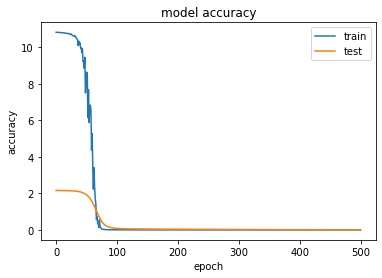

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:
model.save('mbti_rnn.h5')